In [ ]:
"""""""""""""""""""""""""""
---- Imports -----
"""""""""""""""""""""""""""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import sys
from sklearn import preprocessing, svm
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

In [ ]:
"""""""""""""""""""""""""""
---- Helper functions -----
"""""""""""""""""""""""""""

def get_day_of_year(dates):     
  return pd.Period(dates, freq='D').dayofyear

def get_hour_and_minute_of_day(time):
  times = time.split(" ")     
  return (int(times[0])*60+int(times[1])) 

def get_time_of_day(hours):
  if int(hours) >= 6 and int(hours) < 12:     # morning
    return 1
  elif int(hours) >= 12 and int(hours) < 17:  # afternoon
    return 2
  elif int(hours) >= 17 and int(hours) < 22:  # evening
    return 3
  else:                                       # night
    return 4

def address_name(address, side):
  if "/" in address:
    split = address.split("/")
    first = " ".join(split[0].strip().split(" ")[:-1]).split(" ")[-1]
    second = " ".join(split[1].strip().split(" ")[:-1]).split(" ")[-1]
    if side == 1:
      return first
    else:
      return second
  return " ".join(address.split(" ")[:-1]).split(" ")[-1]    

def check_address(address, side):
  if "/" in address:
    split = address.split("/")
    first = split[0].strip().split(" ")[-1]
    second = split[1].strip().split(" ")[-1]
    if side == 1:
      return first
    else:
      return second
  return address.split(" ")[-1]    


x_train = None
y_train = None
x_test = None
y_test = None
x_validation = None
y_validation = None

def preprocess(trainFileName, outputFileName, featuresToDelete, featuresToScale, featuresToEncode, TRAIN_SIZE, VALIDATION_SIZE, TEST_SIZE, df_size):
  # load train file
  drive.mount('/content/drive')
  df = pd.read_csv("drive/MyDrive/" + trainFileName)

  # shuffle data
  df = shuffle(df)

  # use this if data loads too slowly
  if (df_size > 0):
    df = df.sample(n = df_size)
    #df = df[:df_size]

  # Replace bad coordinates with avg
  df.drop_duplicates(inplace=True)
  df.replace({'X': -120.5, 'Y': 90.0}, np.NaN, inplace=True)
  imp = SimpleImputer(strategy='mean')
  for district in df['PdDistrict'].unique():
    df.loc[df['PdDistrict'] == district, ['X', 'Y']] = imp.fit_transform(
        df.loc[df['PdDistrict'] == district, ['X', 'Y']])
 

  """""""""""""""""""""""""""
  ------ Date formats ------
  """""""""""""""""""""""""""

  # Creates new column "DayOfTheYear" with the days of the year.
  df["DayOfTheYear"] = df["Dates"].apply(get_day_of_year)

  # Split "Dates" column into "Date" and "Time".
  df[["Date","Time"]] = df.Dates.str.split(expand=True)

  # Split "Date" into Y/M/D
  df[["Year", "Month", "Day"]] = df.Date.str.split("-", expand=True)

  # Split "Time" into H/M/S
  df[["Hours", "Minutes", "Seconds"]] = df.Time.str.split(":", expand=True)

  # One more column based on the hour of the day
  df["TimeOfDay"] =  df["Hours"].apply(get_time_of_day)

  # Creates new column "HourAndMinuteOfDay" with hour and minute of the day.
  df["HourAndMinuteOfDay"] = (df["Hours"] + " " + df["Minutes"]).apply(get_hour_and_minute_of_day)
  
  # Encode days with Ordinal Encoderrel to numbers
  dayEncoder = OrdinalEncoder()
  df["DayOfWeek"] = dayEncoder.fit_transform(df["DayOfWeek"].values.reshape(-1, 1))



  """""""""""""""""""""""""""""""""""""""""""""
  ------- District and address formats -------
  """""""""""""""""""""""""""""""""""""""""""""

  # Add numbers for each district
  districtEncoder = OrdinalEncoder()
  df["PdDistrict"] = districtEncoder.fit_transform(df["PdDistrict"].values.reshape(-1, 1))

  # Replace address types and add as new column
  df["RoadTypeS1"] = df["Address"].apply(check_address, args=[1])
  df["RoadTypeS2"] = df["Address"].apply(check_address, args=[2])

  # Ordinal for address types
  s1, s2= OrdinalEncoder(), OrdinalEncoder()
  df["RoadTypeS1"] = s1.fit_transform(df["RoadTypeS1"].values.reshape(-1, 1))
  df["RoadTypeS2"] = s2.fit_transform(df["RoadTypeS2"].values.reshape(-1, 1))

  #

  # Replace street names and add as new column
  df["AddressNameS1"] = df["Address"].apply(address_name, args=[1])
  df["AddressNameS2"] = df["Address"].apply(address_name, args=[2])

  # Ordinal for street names
  sn1, sn2= OrdinalEncoder(), OrdinalEncoder()
  df["AddressNameS1"] = sn1.fit_transform(df["AddressNameS1"].values.reshape(-1, 1))
  df["AddressNameS2"] = sn2.fit_transform(df["AddressNameS2"].values.reshape(-1, 1))



  """""""""""""""""""""""""""""""""""
  ------- Other funny stuffs -------
  """""""""""""""""""""""""""""""""""

  # Categories
  cats = set(df["Category"].values)

  # OneHotEncoder
  encoderCategory = OneHotEncoder(sparse=False)
  y = encoderCategory.fit_transform(df["Category"].values.reshape(-1, 1))

  # Delete features
  for feature in featuresToDelete:
    df = df.drop([feature], axis=1)

  # Scale features
  minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
  df[featuresToScale] = minmax_scale.fit_transform(df[featuresToScale])
  #df[['X','Y','Year', 'Month', 'Day', 'Hour', 'Minute','DayOfWeek']] = minmax_scale.fit_transform(df[['X','Y','Year', 'Month', 'Day', 'Hour', 'Minute','DayOfWeek']])


  # Encode features
  for feature in featuresToEncode:
    enc = preprocessing.OneHotEncoder(sparse=False)
    B = enc.fit_transform(df[[feature]])
    df[feature + "_vector"]= np.split(B, B.shape[0])

  # Get rid of unnecessary features
  df = df.drop(columns=["Dates", "Date", "Time", "Category", "Address", "Seconds", "Descript", "Resolution", "Hours", "Minutes", "Month", "Day"])



  """""""""""""""""""""""""""""""""""
  ------- Train, test, valid -------
  """""""""""""""""""""""""""""""""""
  global x_train, y_train, x_test, y_test, x_validation, y_validation

  # Train - Test 
  x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=TEST_SIZE, random_state=9)

  # Train - Validation 
  x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=VALIDATION_SIZE, random_state=9)

  # Save output file

  df.to_csv("drive/MyDrive/" + outputFileName)
  pd.set_option("display.max_rows", None, "display.max_columns", None)
  

In [ ]:
"""""""""""""""""""""""
------ Preprocess ------
"""""""""""""""""""""""

preprocess('train.csv', 'processedTrain.csv', ['RoadTypeS1', 'RoadTypeS2', 'AddressNameS1', 'AddressNameS2','PdDistrict', 'Year'], ['X', 'Y', 'DayOfTheYear', 'HourAndMinuteOfDay','DayOfWeek', 'TimeOfDay'], [], 0.80, 0.20, 0.20, 0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(x_train.shape)
print(x_validation.shape)
print(x_test.shape)

print(y_train.shape)
print(y_validation.shape)
print(y_test.shape)

print(x_test.head(5))



(640, 6)
(160, 6)
(200, 6)
(640, 30)
(160, 30)
(200, 30)
        DayOfWeek         X         Y  DayOfTheYear  TimeOfDay  \
834771   0.166667  0.798670  0.206294      0.590659   0.000000   
799870   0.666667  0.641716  0.636777      0.057692   0.000000   
594190   0.833333  0.164211  0.230043      0.947802   0.333333   
648354   0.166667  0.641930  0.438056      0.175824   0.333333   
484446   0.166667  0.612692  0.316752      0.554945   1.000000   

        HourAndMinuteOfDay  
834771            0.294854  
799870            0.458275  
594190            0.616829  
648354            0.503477  
484446            0.000000  


In [ ]:
"""""""""""""""""""""""""""""""""""
------- Modelling -------
"""""""""""""""""""""""""""""""""""

Peredected values:
[16  1  0 ... 16  7 13]
Actual values:
[20 36 35 ...  4 21 16]
Precision:  0.2624472160435975
Recall:  0.16003168802991807
F1 Score:  0.19775994756389476
Support:  140116


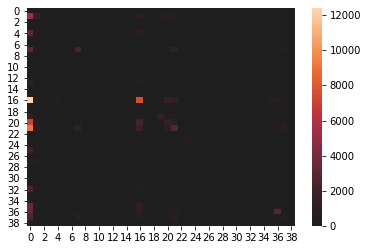

In [ ]:
########################## RandomForest ##########################
def RandomForestAccuracy(x_train, y_train, x_test, y_test, rfc=RandomForestClassifier(random_state=10, n_estimators=3, max_features="auto", max_depth=None, bootstrap=False ), printTable=True):

  rfc.fit(x_train, y_train)
  y_pred = rfc.predict(x_test)

  # ----- prediction vs. reality -----
  print("Peredected values:")
  print(y_pred.argmax(axis=1))
  print("Actual values:")
  print(y_validation.argmax(axis=1))

  #if printTable:
  #  print(classification_report(y_test, y_pred, zero_division=1))

  result = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
  CM = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

  #print("Confusion Matrix: ")
  #print(CM)

  print("Precision: " , result['weighted avg']['precision'])
  print("Recall: " , result['weighted avg']['recall'])
  print("F1 Score: " , result['weighted avg']['f1-score'])
  print("Support: " , result['weighted avg']['support'])

  matplotlib_style = {}

  with plt.rc_context(matplotlib_style):
    plt.figure()
    sns.heatmap(CM, center=True)
    plt.show()


RandomForestAccuracy(x_train, y_train, x_validation, y_validation)

In [ ]:
####################### Bays ###########################
def bays_modelling(x_train, y_train, x_validation, y_validation):
  clf = GaussianNB()
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_validation)
  
  # ----- prediction vs. reality -----
  print("Predected values:")
  print(y_pred)
  print("Actual values:")
  print(y_validation)

  acc = accuracy_score(y_validation,y_pred)
  print('Accuracy: ',acc)

  prec= precision_score(y_validation, y_pred, average='micro')
  print("Precision Score: ", prec)

  rec= recall_score(y_validation, y_pred, average='micro')
  print("Recall Score : ",rec)

  f1 = f1_score(y_validation, y_pred, average='micro')
  print("F1 Score: ", f1)

  cm = confusion_matrix(y_validation, y_pred)
  #print('Confusion matrix: \n', cm)

  matplotlib_style = {}

  with plt.rc_context(matplotlib_style):
    plt.figure()
    sns.heatmap(cm, center=True)
    plt.show()

Predected values:
[16 16 16 ... 16 16 16]
Actual values:
[20 36 35 ...  4 21 16]
Accuracy:  0.2064360958063319
Precision Score:  0.2064360958063319
Recall Score :  0.2064360958063319
F1 Score:  0.2064360958063319


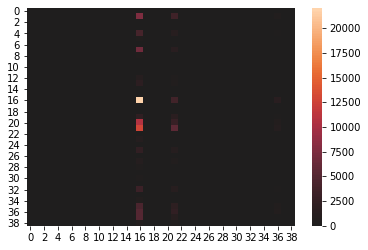

In [ ]:
bays_modelling(x_train, y_train.argmax(axis=1), x_validation, y_validation.argmax(axis=1))

In [ ]:
################################## tpot ####################################

#tpot segítségével megnézzük, hogy az esetleges módszerek közül melyik adja a legjobb eredményt, viszont az egész adathalmaz esetén 70 óra a futási idő, 
#ezért 300-ra csökkenttük (ahol sajnos csak 23 kategóriát vett alapul), és ekkor 1.0 score-t adott az ExtraTreesClassifier esetén
!pip install tpot
from tpot import TPOTClassifier

#y_train átformálása a feladathoz mérten
df2 = pd.DataFrame(y_train, columns = ['Column_1','Column_2','Column_3','Column_4','Column_5','Column_6','Column_7','Column_8','Column_9','Column_10','Column_11','Column_12','Column_13','Column_14','Column_15','Column_16','Column_17','Column_18','Column_19','Column_20','Column_21','Column_22','Column_23'])
y_train_shaped = df2.fillna('').sum(1)
features_train = y_train_shaped.values.reshape(-1, 1)

tpot.fit(x_train,features_train)

#Melyik a legjobb modell? Nekünk az ExtraTreesClassifier-t adta eredményül 300 adat esetén
tpot.fitted_pipeline_

df3 = pd.DataFrame(y_test, columns = ['Column_1','Column_2','Column_3','Column_4','Column_5','Column_6','Column_7','Column_8','Column_9','Column_10','Column_11','Column_12','Column_13','Column_14','Column_15','Column_16','Column_17','Column_18','Column_19','Column_20','Column_21','Column_22','Column_23'])
y_test_shaped = df3.fillna('').sum(1)
features_test = y_test_shaped.values.reshape(-1, 1)

#1.0-t kaptunk eredményül
tpot.score(x_test, features_test)

In [ ]:
#Az egész adathalmaz esetén összeomlik, viszont 10 000 adat esetén 0.02-t ad eredményül
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics

extra_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=4)

def compute_accuracy(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(x_test)
    acc_score = metrics.accuracy_score(y_test, clf_pred)
    return acc_score

extra_clf = ExtraTreesClassifier(n_estimators=100, n_jobs=6)
extra_clf_acc = compute_accuracy(extra_clf, x_train, y_train, x_test, y_test)
print('Extra Tree Forest Accuracy : %.2f' % extra_clf_acc)

In [ ]:
################ Catboost #######################
!pip install catboost

In [ ]:
# Catboost

from catboost.utils import get_gpu_device_count
from catboost import CatBoostClassifier, Pool

# Megnézzük hány GPU-n tudjuk futtatni a CatBoost-ot.
print('I see %i GPU devices' % get_gpu_device_count())

# Train test pool-ok létrehozása a CatBoost modelhez
train_pool = Pool(data=x_train, label=y_train.argmax(axis=1))
test_pool = Pool(data=x_test, label=y_test.argmax(axis=1))

# Model létrehozása
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,                # Túl nagy és túl kicsi learning rate nem adott jó megoldást.
    random_strength=0.1,
    depth=8,                          # Fakeresés mélység
    loss_function='MultiClass',
    eval_metric='Accuracy',
    leaf_estimation_method='Newton',  # Fakeresés levél kiértékelés függvény
    task_type='GPU',                  # CPU vagy GPU, de GPU-n sokkal gyorsabb a model illesztés
    devices='0:1'
) 

model.fit(train_pool, plot=True, eval_set=test_pool)

I see 1 GPU devices


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2333923	test: 0.2330627	best: 0.2330627 (0)	total: 106ms	remaining: 10.5s
1:	learn: 0.2339044	test: 0.2335823	best: 0.2335823 (1)	total: 195ms	remaining: 9.56s
2:	learn: 0.2342434	test: 0.2341018	best: 0.2341018 (2)	total: 284ms	remaining: 9.19s
3:	learn: 0.2352640	test: 0.2348897	best: 0.2348897 (3)	total: 391ms	remaining: 9.38s
4:	learn: 0.2356886	test: 0.2354379	best: 0.2354379 (4)	total: 514ms	remaining: 9.76s
5:	learn: 0.2366593	test: 0.2361801	best: 0.2361801 (5)	total: 618ms	remaining: 9.68s
6:	learn: 0.2383668	test: 0.2379386	best: 0.2379386 (6)	total: 710ms	remaining: 9.43s
7:	learn: 0.2381580	test: 0.2379786	best: 0.2379786 (7)	total: 793ms	remaining: 9.12s
8:	learn: 0.2383275	test: 0.2380243	best: 0.2380243 (8)	total: 892ms	remaining: 9.02s
9:	learn: 0.2402081	test: 0.2399541	best: 0.2399541 (9)	total: 973ms	remaining: 8.76s
10:	learn: 0.2419014	test: 0.2417126	best: 0.2417126 (10)	total: 1.06s	remaining: 8.55s
11:	learn: 0.2425472	test: 0.2422665	best: 0.2422665

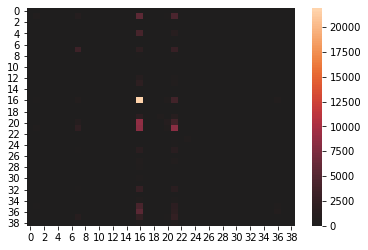

0.26403123126552286

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Validálás
pred = model.predict(x_validation)
CM = confusion_matrix(y_validation.argmax(axis=1), pred)
matplotlib_style = {}

# Confusion matrix CatBoost
with plt.rc_context(matplotlib_style):
  plt.figure()
  sns.heatmap(CM, center=True)
  plt.show()

# Final accuracy
accuracy_score(y_validation.argmax(axis=1), pred)

In [ ]:
##################################################################################################################################################
##################################################################################################################################################
########################################### Az ez utáni részeket nem használtuk a végső verzióban ################################################

In [ ]:
############### Baseline #####################
def Baseline(x_train, x_validation, y_train, y_validation):
  #base_line = DummyClassifier(strategy='most_frequent')
  base_line = DummyClassifier(strategy='uniform')
  base_line.fit(x_train,y_train)
  y_pred = base_line.predict(x_validation)

  # ----- prediction vs. reality -----
  print("Predected values:")
  print(y_pred.argmax(axis=1))
  print("Actual values:")
  print(y_validation.argmax(axis=1))

  cm = confusion_matrix(y_validation.argmax(axis=1), y_pred.argmax(axis=1))
  #print('Confusion matrix: \n', cm)
  acc = accuracy_score(y_validation,y_pred)
  print('Accuracy: ',acc)
  prec= precision_score(y_validation, y_pred, #pos_label='positive', 
                          average='micro')
  print("Precision Score : ", prec)
  rec= recall_score(y_validation, y_pred, #pos_label='positive',
                      average='micro')
  print("Recall Score : ",rec)
  f1 = f1_score(y_validation, y_pred, average='micro')
  print("F1 Score: ", f1)
  matplotlib_style = {}
  with plt.rc_context(matplotlib_style):
    plt.figure()
    sns.heatmap(cm, center=True)
    plt.show()

Predected values:
[0 3 0 ... 1 0 1]
Actual values:
[20 36 35 ...  4 21 16]
Accuracy:  0.0
Precision Score :  0.025598508982436857
Recall Score :  0.49933626423820265
F1 Score:  0.04870038906714027


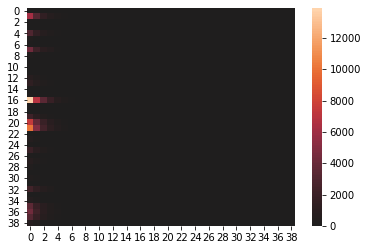

In [ ]:
Baseline(x_train,x_validation,y_train,y_validation)

In [ ]:
####################### KNN ###########################
def KNN(x_train,x_validation,y_train,y_validation):
   classifier = KNeighborsClassifier(n_neighbors=3)
   classifier.fit(x_train, y_train)
   y_pred = classifier.predict(x_validation)

   # ----- prediction vs. reality -----
   print("Peredected values:")
   print(y_pred.argmax(axis=1))
   print("Actual values:")
   print(y_validation.argmax(axis=1))
   
   #print(classification_report(y_validation, y_pred))

   cm = confusion_matrix(y_validation.argmax(axis=1), y_pred.argmax(axis=1))
   #print('Confusion matrix: \n', cm)
   acc=accuracy_score(y_validation.argmax(axis=1), y_pred.argmax(axis=1))
   print('Accuracy: ',acc)
   prec= precision_score(y_validation, y_pred, average='micro')
   print("Precision Score : ", prec)
   rec= recall_score(y_validation, y_pred, average='micro')
   print("Recall Score : ", rec)

   f1 = f1_score(y_validation.argmax(axis=1), y_pred.argmax(axis=1), average='micro')
   print("F1 Score: ", f1)
   matplotlib_style = {}
   with plt.rc_context(matplotlib_style):
     plt.figure()
     sns.heatmap(cm, center=True)
     plt.show()

Peredected values:
[16  0  0 ... 16  7  0]
Actual values:
[20 36 35 ...  4 21 16]
Accuracy:  0.09474292728881784
Precision Score :  0.24172722912900726
Recall Score :  0.09352964686402696
F1 Score:  0.09474292728881784


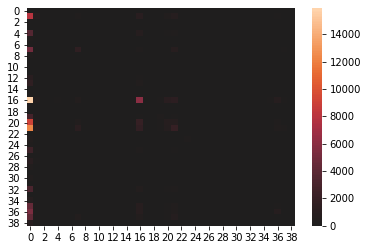

In [ ]:
KNN(x_train, x_validation, y_train, y_validation)

In [ ]:
################## RandomizedSearch ######################
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
tuned_parameters = [{'n_neighbors': [3,4,5,19,54]}]
scoring='accuracy'
base_model = KNeighborsClassifier()
clf = RandomizedSearchCV(base_model, tuned_parameters, cv=5, scoring=scoring,return_train_score=True,refit=True)
clf.fit(x_train,y_train)
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.088 (+/-0.001) for {'n_neighbors': 3}
0.033 (+/-0.001) for {'n_neighbors': 4}
0.057 (+/-0.001) for {'n_neighbors': 5}
0.015 (+/-0.000) for {'n_neighbors': 19}
0.003 (+/-0.000) for {'n_neighbors': 54}


In [ ]:
train_means = clf.cv_results_['mean_train_score']
train_stds = clf.cv_results_['std_train_score']
for mean, std, params in zip(train_means, train_stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

0.320 (+/-0.028) for {'n_neighbors': 3}
0.105 (+/-0.012) for {'n_neighbors': 4}
0.167 (+/-0.021) for {'n_neighbors': 5}
0.027 (+/-0.016) for {'n_neighbors': 19}
0.003 (+/-0.006) for {'n_neighbors': 54}


In [ ]:
print(clf.param_grid)
n_neigh=clf.param_grid[0]['n_neighbors']
#display the means and stdd_dev
plt.plot(n_neigh,train_means,label='train-acc',c='b')
plt.fill_between(n_neigh, train_means - train_stds, train_means + train_stds, alpha=0.1, color="b")

plt.plot(n_neigh,val_means,label='val-acc',c='g')
plt.fill_between(n_neigh, val_means - val_stds, val_means + val_stds, alpha=0.1, color="g")

#you can plot a single point as well
plt.plot(clf.best_params_['n_neighbors'],clf.best_score_,'o',color='r',label='best')

plt.xlabel("n_neighbors")
plt.ylabel('accuracy')
# Tplt.legend()

NameError: ignored

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

tuned_parameters = [{'n_estimators': [3,5,10,15,20,30,42,54]}, {'max_depth': [3,5,10,100, None]}, {'max_features': ["auto", "sqrt", "log2"]}, {'bootstrap': [True, False]}]
scoring='accuracy'
base_model = RandomForestClassifier()
clf = RandomizedSearchCV(base_model, tuned_parameters, cv=5, scoring=scoring,return_train_score=True,refit=True)

clf.fit(x_train,y_train)
print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

KeyboardInterrupt: ignored

In [ ]:
################### SVC #########################
from sklearn.model_selection import GridSearchCV

def svc_modelling(gamma, C, kernel, x_train, y_train, x_validation, y_validation, average):
  clf = svm.SVC(gamma=gamma, C=C)
  clf.fit(x_train, y_train)  
  y_pred = clf.predict(x_validation)

  # Conf matrix --------------
  cm = confusion_matrix(y_validation, y_pred)
  matplotlib_style = {}
  with plt.rc_context(matplotlib_style):
    plt.figure()
    sns.heatmap(cm, center=True)
    plt.show()

  # Metrics --------------
  acc = clf.score(x_train, y_train)
  print("\nAccuracy:\t\t\t", acc)

  prec= precision_score(y_validation, y_pred, average=average)
  print("Precision Score:\t\t", prec)

  rec= recall_score(y_validation, y_pred, average=average)
  print("Recall Score:\t\t\t", rec)

  f1 = f1_score(y_validation, y_pred, average=average)
  print("F1 Score:\t\t\t", f1)

svc_modelling('scale', 6000.0, 'rbf', x_train, y_train.argmax(axis=1), x_validation, y_validation.argmax(axis=1), 'micro')

In [ ]:
tuned_parameters = [{'kernel': ['linear','rbf'], 'C': [10, 100, 6000], 'gamma': ['scale', 'auto']}]
scoring='accuracy'
  
base_model = svm.SVC()
clf = GridSearchCV(base_model, tuned_parameters, cv=5, scoring=scoring, return_train_score=True, refit=True)
clf.fit(x_train, y_train.argmax(axis=1))  
y_pred = clf.predict(x_validation)

print("Best parameters set found on development set:\n")
print(clf.best_params_)
print("\nGrid scores on development set:\n")
val_means = clf.cv_results_['mean_test_score']
val_stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(val_means, val_stds, clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters set found on development set:

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Grid scores on development set:

0.304 (+/-0.037) for {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
0.288 (+/-0.075) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.304 (+/-0.037) for {'C': 10, 'gamma': 'auto', 'kernel': 'linear'}
0.302 (+/-0.033) for {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.300 (+/-0.030) for {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
0.241 (+/-0.038) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.300 (+/-0.030) for {'C': 100, 'gamma': 'auto', 'kernel': 'linear'}
0.294 (+/-0.034) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.296 (+/-0.024) for {'C': 6000, 'gamma': 'scale', 'kernel': 'linear'}
0.213 (+/-0.074) for {'C': 6000, 'gamma': 'scale', 'kernel': 'rbf'}
0.296 (+/-0.024) for {'C': 6000, 'gamma': 'auto', 'kernel': 'linear'}
0.255 (+/-0.025) for {'C': 6000, 'gamma': 'auto', 'kernel': 'rbf'}
